In [89]:
# Importing all the libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
# Loading the dataset
concrete_data = pd.read_csv('./concrete_data.csv')

In [21]:
# printing the five rows and columns of dataset
concrete_data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [22]:
# Printing the last 5 rows
concrete_data.tail()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


In [23]:
# shape of dataset
print(f'Total number of the rows  = {concrete_data.shape[0]} and the total number of column = {concrete_data.shape[1]}')

Total number of the rows  = 1030 and the total number of column = 9


In [24]:
# Basic Information of the data
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [25]:
# checking the total number of non unique elemen
concrete_data.nunique()

cement                           278
blast_furnace_slag               185
fly_ash                          156
water                            195
superplasticizer                 111
coarse_aggregate                 284
fine_aggregate                   302
age                               14
concrete_compressive_strength    845
dtype: int64

In [26]:
# checking duplicated columns
concrete_data.duplicated().sum()

25

### Observation
- There is 25 duplicated values is present
- Droping all duplicated values

In [27]:
# Droping all the duplicate from the dataset
concrete_data.drop_duplicates(inplace=True)

In [28]:
# decription of columns
concrete_data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716,35.250378
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692,16.284815
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000,23.520000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.800000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000,44.870000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [29]:
# Checking the number of null value present
concrete_data.isnull().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

#### Observation there is no null value present in the dataset

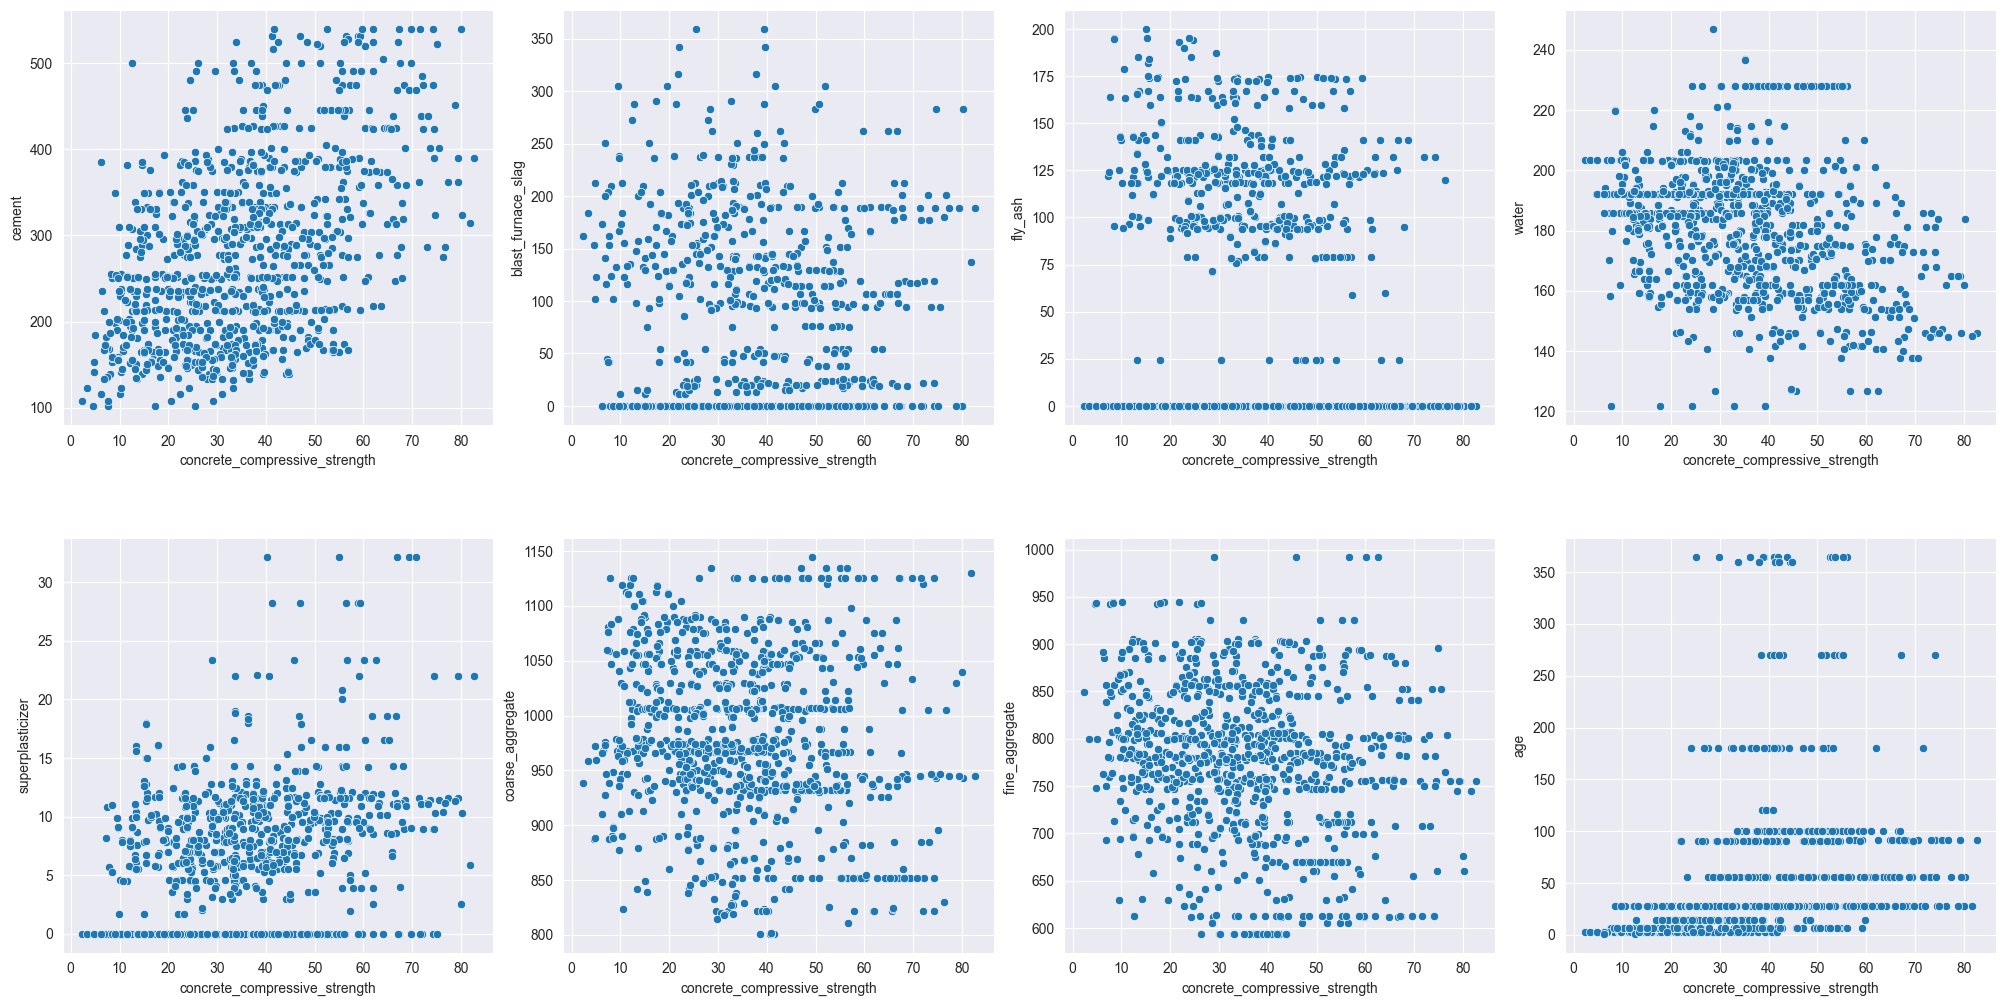

In [30]:
# EDA
# Plotting scatter plot w.r.t strength
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()
for col in concrete_data.columns:
    if col != "concrete_compressive_strength":
        sns.scatterplot(x="concrete_compressive_strength", y=col, data=concrete_data, ax=ax[index])
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


#### Observation
1. Concreate_Compressive_Strength and cement has linear relation ship
2. Concreate_Compressive_strength and superplasticizer has linear relation
3. other columns  are nont linear related to other

In [31]:
# Checking the skewness
concrete_data.skew()

cement                           0.564959
blast_furnace_slag               0.855225
fly_ash                          0.497231
water                            0.034433
superplasticizer                 0.980604
coarse_aggregate                -0.065256
fine_aggregate                  -0.252353
age                              3.253974
concrete_compressive_strength    0.395696
dtype: float64

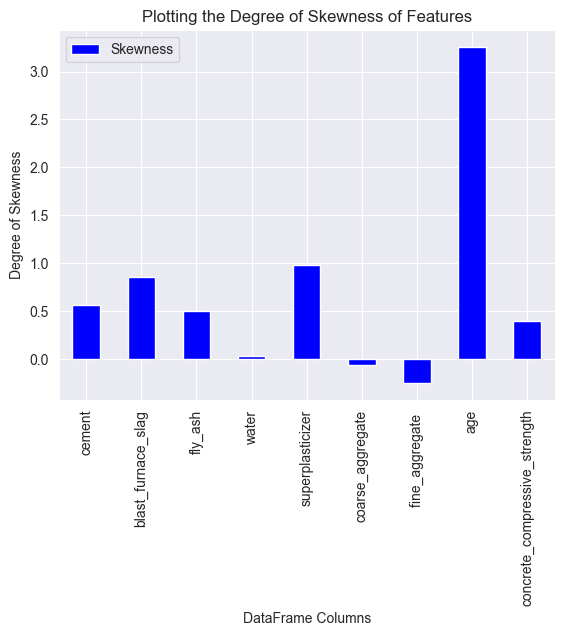

In [32]:
# checking the skewnessand plotting the bar graph
concrete_data.skew().plot(kind='bar', color='blue')
plt.xlabel("DataFrame Columns")
plt.ylabel("Degree of Skewness") 
plt.title("Plotting the Degree of Skewness of Features") 
plt.legend(["Skewness"]) 
plt.show()

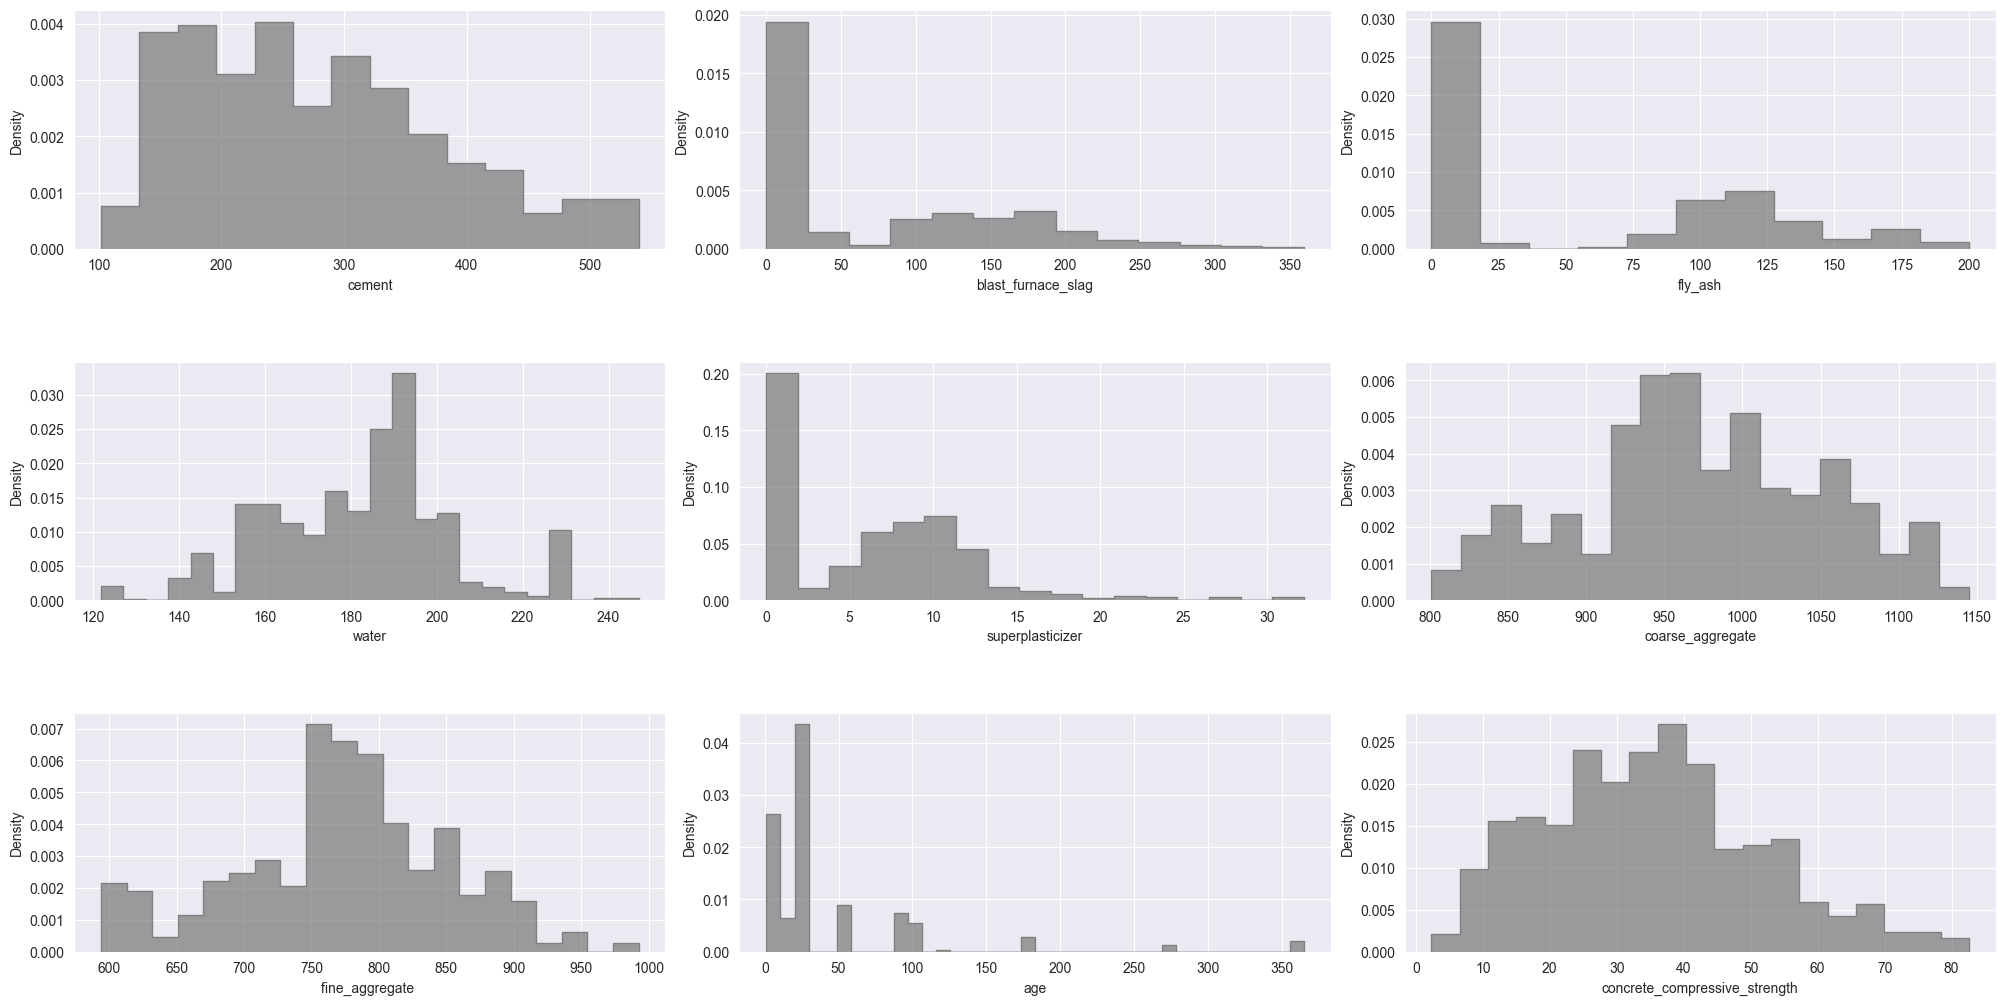

In [33]:
# Define figure and axes
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

index = 0
ax = ax.flatten()  # Flatten the array of axes for easier iteration
for col in concrete_data.columns:
    sns.histplot(x=col, data=concrete_data, ax=ax[index], element='step', stat='density', common_norm=False, color='Grey')
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()


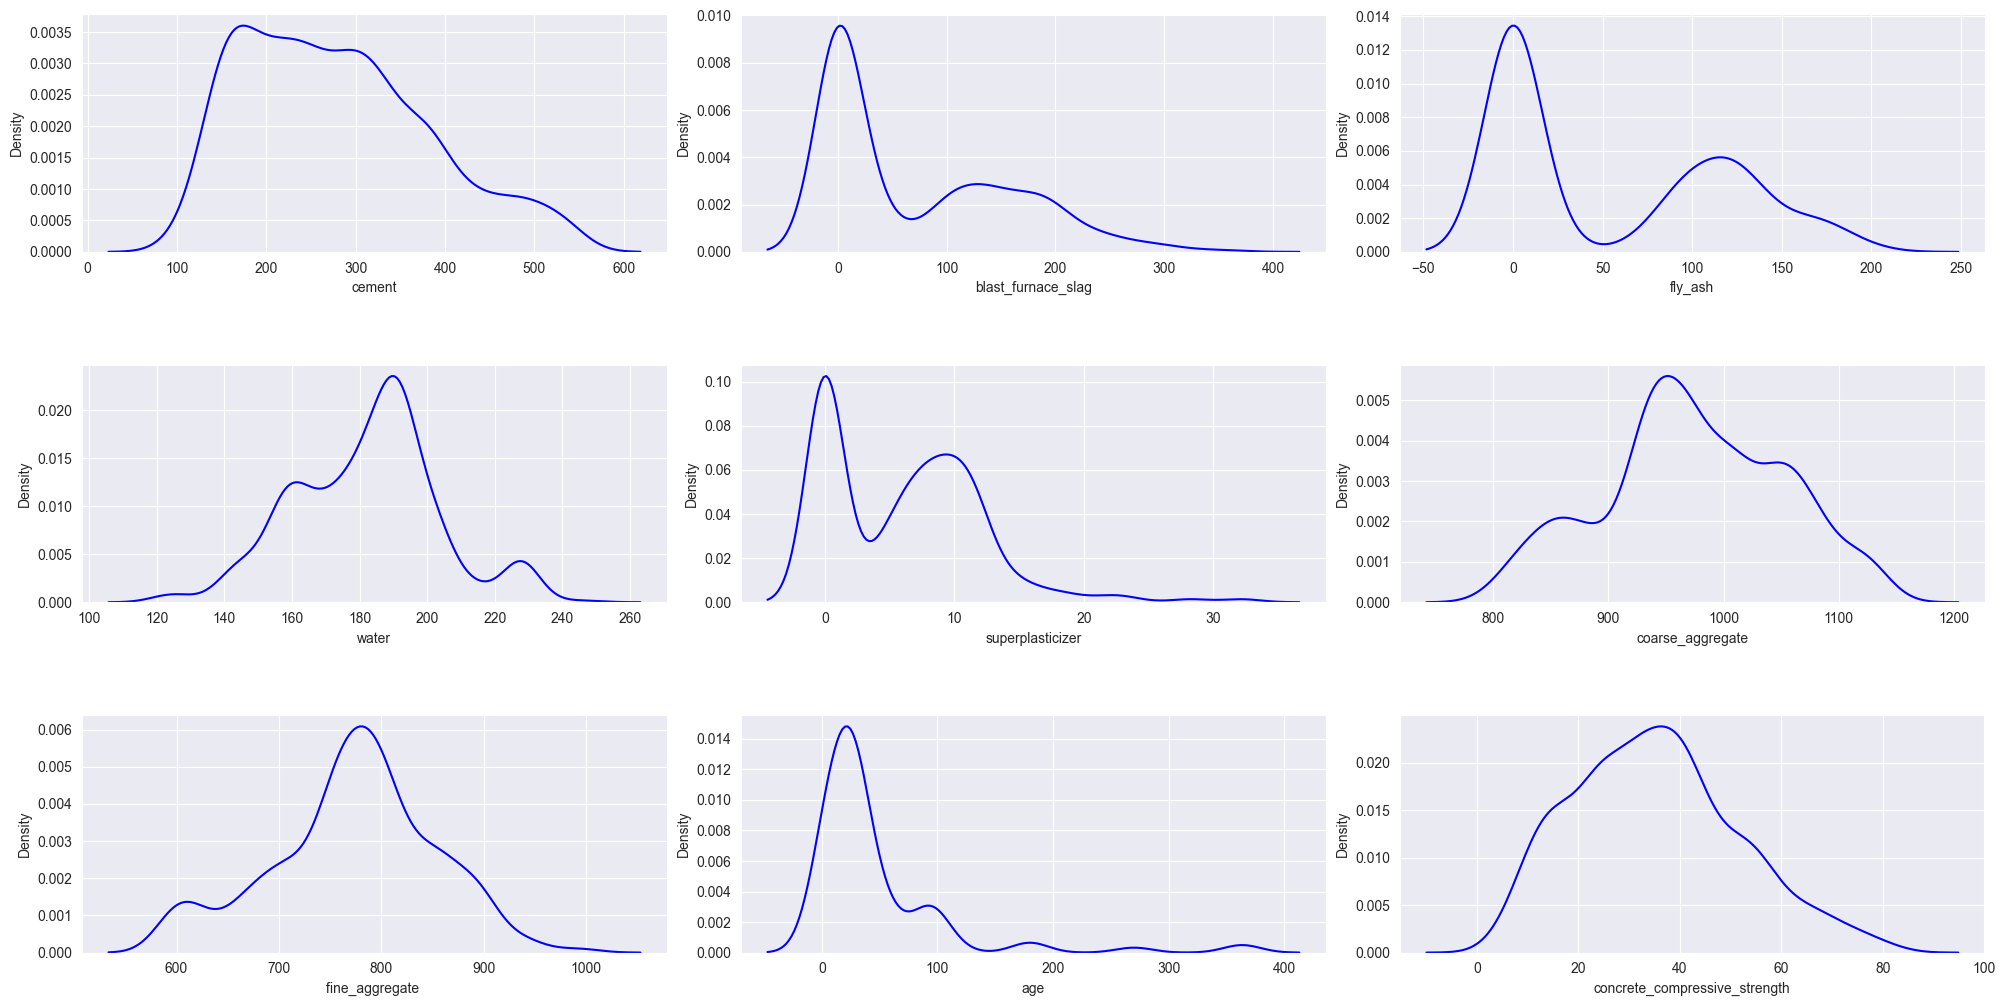

In [34]:
# hist plot of data
# plotting scatter plot w.r.t strength
fig , ax = plt.subplots(ncols=3,nrows=3,figsize=(20,10))
index = 0
ax = ax.flatten()

for col in concrete_data.columns:
    sns.kdeplot(x=col,data=concrete_data,ax=ax[index],color='blue')
    index+=1
plt.tight_layout(pad=0.5,w_pad=0.7,h_pad=5.0)

#### Observation
1. Blast_Furnance_Slag,Age,SuperPlasticizer, Fly_ast are Right Skewed
2. Other columns are normally distributed

In [35]:
# Corellation of target variable
concrete_data.corr()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
cement,1.000000,-0.303324,-0.385610,-0.056625,0.060906,-0.086205,-0.245375,0.086348,0.488283
blast_furnace_slag,-0.303324,1.000000,-0.312352,0.130262,0.019800,-0.277559,-0.289685,-0.042759,0.103374
fly_ash,-0.385610,-0.312352,1.000000,-0.283314,0.414213,-0.026468,0.090262,-0.158940,-0.080648
water,-0.056625,0.130262,-0.283314,1.000000,-0.646946,-0.212480,-0.444915,0.279284,-0.269624
superplasticizer,0.060906,0.019800,0.414213,-0.646946,1.000000,-0.241721,0.207993,-0.194076,0.344209
coarse_aggregate,-0.086205,-0.277559,-0.026468,-0.212480,-0.241721,1.000000,-0.162187,-0.005264,-0.144717
fine_aggregate,-0.245375,-0.289685,0.090262,-0.444915,0.207993,-0.162187,1.000000,-0.156572,-0.186448
age,0.086348,-0.042759,-0.158940,0.279284,-0.194076,-0.005264,-0.156572,1.000000,0.337367
concrete_compressive_strength,0.488283,0.103374,-0.080648,-0.269624,0.344209,-0.144717,-0.186448,0.337367,1.000000


In [36]:
# Correlation of conreate_comprensive_strength with other variable
concrete_data.corr()['concrete_compressive_strength']

cement                           0.488283
blast_furnace_slag               0.103374
fly_ash                         -0.080648
water                           -0.269624
superplasticizer                 0.344209
coarse_aggregate                -0.144717
fine_aggregate                  -0.186448
age                              0.337367
concrete_compressive_strength    1.000000
Name: concrete_compressive_strength, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


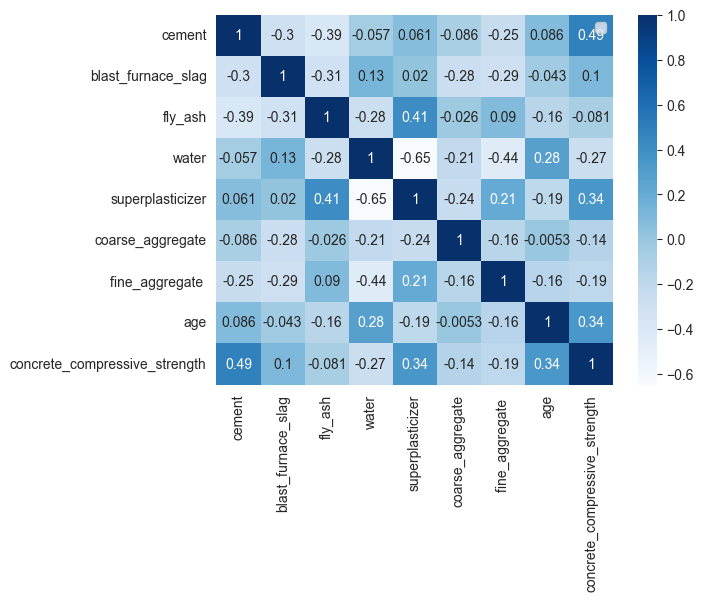

In [37]:
# heatmap of correlation
sns.heatmap(concrete_data.corr(),annot=True,cmap='Blues')
plt.legend()
plt.show()

#### Observation
1. Cement has Higest correlation with Concrete Strength
2. Blast_furnace_slag and Fly has least Correation with concrete strenght
3. superplasticizer and age has similar correlation with concrete strenght
4. water has higest negative correlation with concrete strenght
coarse_aggregate and fine aggregate has similar negative correation with concreate strength

## Handline Outliers

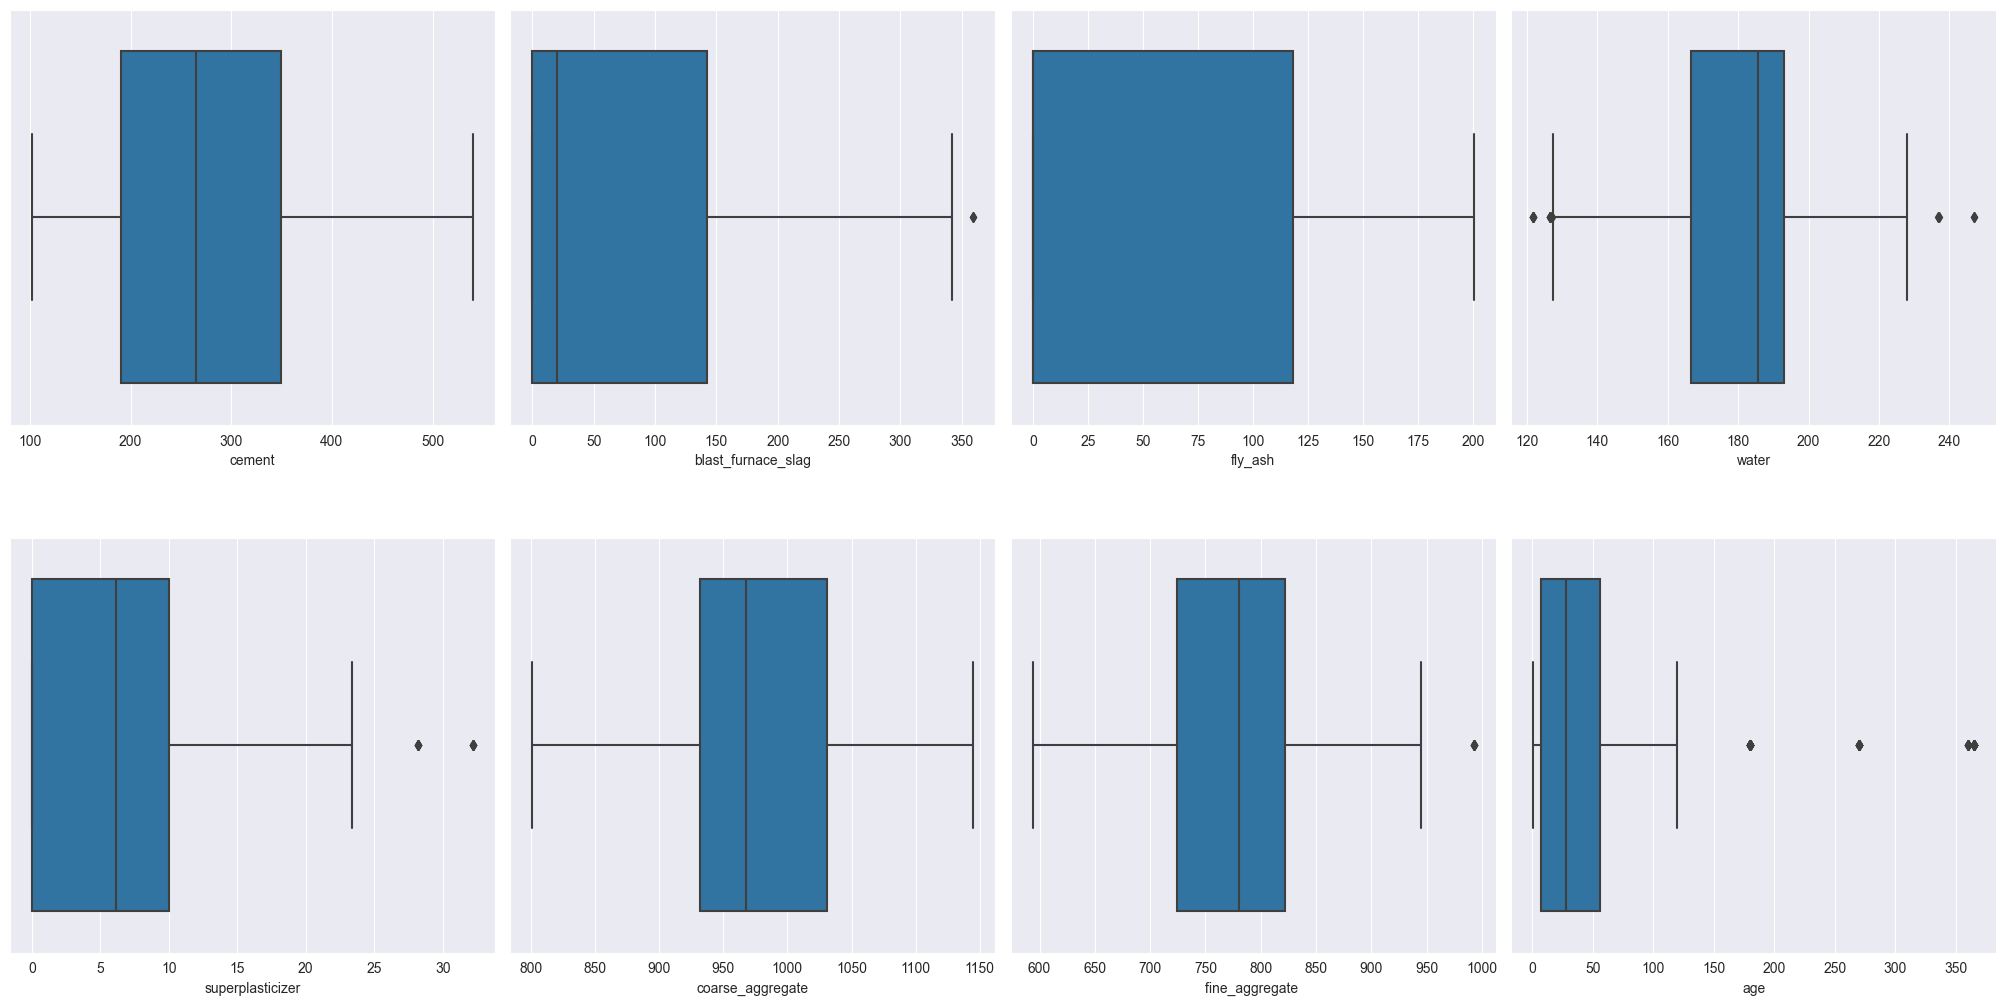

In [38]:
fig,ax = plt.subplots(ncols=4,nrows=2,figsize=(20,10))
index = 0
ax = ax.flatten()

for col in concrete_data.columns:
    if col!="concrete_compressive_strength":
        sns.boxplot(x=col,data=concrete_data,ax=ax[index])
        index+=1
plt.tight_layout(pad=0.5,w_pad=0.7,h_pad=5.0)

There is no outlier present

#### Feature Engineering

In [39]:
# 1. Numerical Features
num_features = [feature for feature in concrete_data.columns if concrete_data[feature].dtype!='0']
print(f'Number of numerical features : {len(num_features)}')

Number of numerical features : 9


In [40]:
# Categorical Features
cat_features = [feature  for feature in concrete_data.columns if concrete_data[feature].dtype=='0']
print(f'Number of Numerical Features : {len(cat_features)}')

Number of Numerical Features : 0


In [41]:
# Discreate Features
discreate_feature = [feature for feature in num_features if len(concrete_data[feature].unique())<=25]
print(f'Number of discreate feature : {len(discreate_feature)}')

Number of discreate feature : 1


### Feature selection

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, concrete_data):
    
    X = concrete_data[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

compute_vif(num_features, concrete_data)

,Variable,VIF
0,cement,8.873655
1,blast_furnace_slag,7.962600
2,fly_ash,6.372262
3,water,6.938969
4,superplasticizer,2.894421
5,coarse_aggregate,4.970294
6,fine_aggregate,6.992948
7,age,1.606716
8,concrete_compressive_strength,2.524502


#### Splitting into train and test

In [43]:
# Separate features and target
from sklearn.model_selection import train_test_split
X = concrete_data.drop('concrete_compressive_strength', axis=1)
y = concrete_data['concrete_compressive_strength']

In [44]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Non-Ensemble Algorithms

#### Linear Regression

In [46]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [47]:
# Make predictions on the test set
y_pred = linear_model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f"Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Linear Regression Performance:
Mean Absolute Error (MAE): 8.90
Mean Squared Error (MSE): 125.25
Root Mean Squared Error (RMSE): 11.19
R² Score: 0.58


#### Ridge Regression

In [48]:
# Initialize and train Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [49]:
# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [50]:
# Evaluate Ridge Regression
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mse_ridge ** 0.5
r2_ridge = r2_score(y_test, y_pred_ridge)

# Display Ridge Regression metrics
print("Ridge Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.2f}")

Ridge Regression Performance:
Mean Absolute Error (MAE): 8.90
Mean Squared Error (MSE): 125.29
Root Mean Squared Error (RMSE): 11.19
R² Score: 0.58


#### Lasso Regression

In [51]:
# Initialize and train Lasso Regression
lasso_model = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [52]:
# Make predictions on the test set
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [53]:
# Evaluate Lasso Regression
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = mse_lasso ** 0.5
r2_lasso = r2_score(y_test, y_pred_lasso)

# Display Lasso Regression metrics
print("Lasso Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_lasso:.2f}")
print(f"Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.2f}")
print(f"R² Score: {r2_lasso:.2f}")

Lasso Regression Performance:
Mean Absolute Error (MAE): 8.92
Mean Squared Error (MSE): 126.10
Root Mean Squared Error (RMSE): 11.23
R² Score: 0.58


#### K-Nearest Neighbors (KNN)

In [54]:
# Initialize and train KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=100)  
knn_model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=100)

In [55]:
# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Display results
print("KNN Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_knn:.2f}")
print(f"Mean Squared Error (MSE): {mse_knn:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn:.2f}")
print(f"R² Score: {r2_knn:.2f}")


KNN Regression Performance:
Mean Absolute Error (MAE): 11.15
Mean Squared Error (MSE): 196.37
Root Mean Squared Error (RMSE): 14.01
R² Score: 0.34


#### Decision Tree

In [56]:
# Initialize and train the Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [57]:
# Make predictions on the test set
y_pred_tree = tree_model.predict(X_test_scaled)

In [58]:
# Evaluate the Decision Tree Regressor
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = mse_tree ** 0.5
r2_tree = r2_score(y_test, y_pred_tree)

# Display evaluation metrics
print(f"Decision Tree Performance:")
print(f"Mean Absolute Error (MAE): {mae_tree:.2f}")
print(f"Mean Squared Error (MSE): {mse_tree:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tree:.2f}")
print(f"R² Score: {r2_tree:.2f}")

Decision Tree Performance:
Mean Absolute Error (MAE): 3.76
Mean Squared Error (MSE): 35.00
Root Mean Squared Error (RMSE): 5.92
R² Score: 0.88


#### Multivariate Polynomial Regression

In [59]:
#Generate polynomial features:

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

In [60]:
# Train Linear Regression on polynomial features
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [61]:
# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Display results
print("Multivariate Polynomial Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_poly:.2f}")
print(f"Mean Squared Error (MSE): {mse_poly:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_poly:.2f}")
print(f"R² Score: {r2_poly:.2f}")


Multivariate Polynomial Regression Performance:
Mean Absolute Error (MAE): 8.90
Mean Squared Error (MSE): 125.25
Root Mean Squared Error (RMSE): 11.19
R² Score: 0.58


#### Random forest

In [62]:
# Initialize and train the Random Forest Regressor
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [63]:
# Make predictions on the test set
y_pred_forest = forest_model.predict(X_test_scaled)

In [64]:
# Evaluate the Random Forest Regressor
mae_forest = mean_absolute_error(y_test, y_pred_forest)
mse_forest = mean_squared_error(y_test, y_pred_forest)
rmse_forest = mse_forest ** 0.5
r2_forest = r2_score(y_test, y_pred_forest)

# Display evaluation metrics
print(f"Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_forest:.2f}")
print(f"Mean Squared Error (MSE): {mse_forest:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_forest:.2f}")
print(f"R² Score: {r2_forest:.2f}")

Random Forest Performance:
Mean Absolute Error (MAE): 3.50
Mean Squared Error (MSE): 27.62
Root Mean Squared Error (RMSE): 5.26
R² Score: 0.91


#### Gradient Boosting Regressor

In [65]:
# Initialize and train the Gradient Boosting Regressor
gboost_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gboost_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [66]:
# Make predictions on the test set
y_pred_gboost = gboost_model.predict(X_test_scaled)

In [67]:
# Evaluate the Gradient Boosting Regressor
mae_gboost = mean_absolute_error(y_test, y_pred_gboost)
mse_gboost = mean_squared_error(y_test, y_pred_gboost)
rmse_gboost = mse_gboost ** 0.5
r2_gboost = r2_score(y_test, y_pred_gboost)

# Display evaluation metrics
print(f"Gradient Boosting Performance:")
print(f"Mean Absolute Error (MAE): {mae_gboost:.2f}")
print(f"Mean Squared Error (MSE): {mse_gboost:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gboost:.2f}")
print(f"R² Score: {r2_gboost:.2f}")

Gradient Boosting Performance:
Mean Absolute Error (MAE): 4.13
Mean Squared Error (MSE): 31.40
Root Mean Squared Error (RMSE): 5.60
R² Score: 0.89


#### Support vector Regresssion

In [68]:
# Initialize and train the Support Vector Regressor
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

SVR(C=100)

In [69]:
# Make predictions on the test set
y_pred_svr = svr_model.predict(X_test_scaled)

In [70]:
# Evaluate the Support Vector Regressor
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mse_svr ** 0.5
r2_svr = r2_score(y_test, y_pred_svr)

# Display evaluation metrics
print(f"Support Vector Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_svr:.2f}")
print(f"Mean Squared Error (MSE): {mse_svr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr:.2f}")
print(f"R² Score: {r2_svr:.2f}")

Support Vector Regression Performance:
Mean Absolute Error (MAE): 4.02
Mean Squared Error (MSE): 35.69
Root Mean Squared Error (RMSE): 5.97
R² Score: 0.88


In [71]:
# Evaluate the Support Vector Regressor
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mse_svr ** 0.5
r2_svr = r2_score(y_test, y_pred_svr)

# Display evaluation metrics
print(f"Support Vector Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_svr:.2f}")
print(f"Mean Squared Error (MSE): {mse_svr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr:.2f}")
print(f"R² Score: {r2_svr:.2f}")

Support Vector Regression Performance:
Mean Absolute Error (MAE): 4.02
Mean Squared Error (MSE): 35.69
Root Mean Squared Error (RMSE): 5.97
R² Score: 0.88


#### Neural Networks

In [72]:
# Initialize and train the Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', 
                        max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=42)

In [73]:
# Make predictions on the test set
y_pred_nn = nn_model.predict(X_test_scaled)

In [74]:
# Evaluate the Neural Network
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = mse_nn ** 0.5
r2_nn = r2_score(y_test, y_pred_nn)

# Display evaluation metrics
print(f"Neural Network Performance:")
print(f"Mean Absolute Error (MAE): {mae_nn:.2f}")
print(f"Mean Squared Error (MSE): {mse_nn:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn:.2f}")
print(f"R² Score: {r2_nn:.2f}")

Neural Network Performance:
Mean Absolute Error (MAE): 4.45
Mean Squared Error (MSE): 40.45
Root Mean Squared Error (RMSE): 6.36
R² Score: 0.86


#### Comparing non-ensemble Models 
- Linear Regression
- Ridge
- Lasso Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- Support Vector Regressor (SVR)
- Neural Networks

In [75]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "SVR": SVR(kernel="rbf", C=100, epsilon=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Multivariate Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', max_iter=1000, random_state=42)
}


                                Model       MAE         MSE       RMSE  \
0                   Linear Regression  8.895256  125.245648  11.191320   
1                    Ridge Regression  8.895254  125.245503  11.191314   
2                    Lasso Regression  8.895183  125.224496  11.190375   
3                                 SVR  7.185714   92.809524   9.633770   
4                                 KNN  7.250975   90.178581   9.496240   
5                       Decision Tree  3.775547   35.090812   5.923750   
6  Multivariate Polynomial Regression  6.217066   68.978990   8.305359   
7                      Neural Network  6.299535   74.892975   8.654073   

         R²  
0  0.580170  
1  0.580171  
2  0.580241  
3  0.688898  
4  0.697717  
5  0.882374  
6  0.768779  
7  0.748955  


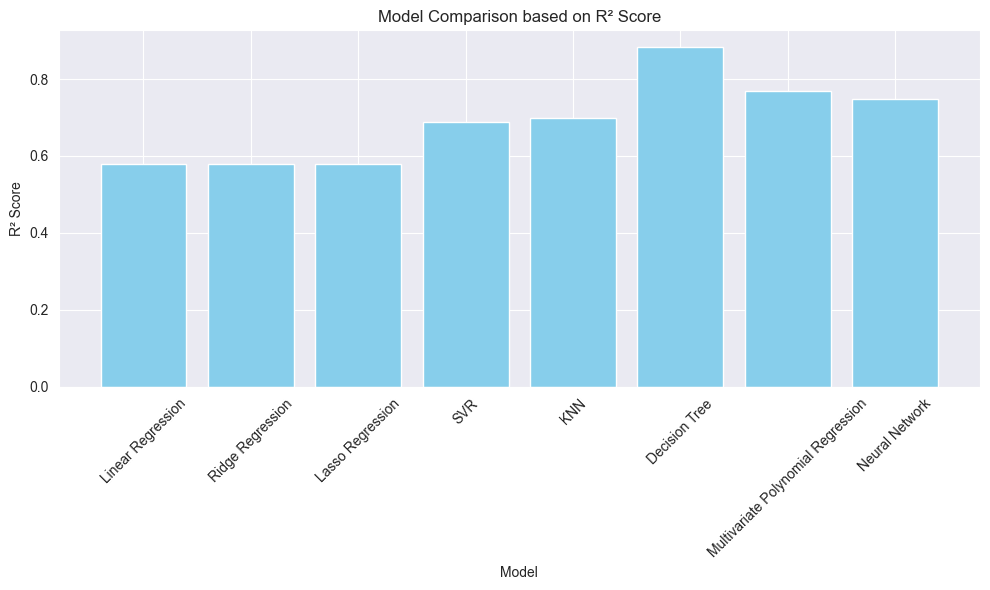

In [76]:
# Evaluate models
results = []

for name, model in models.items():
    if 'Polynomial Regression' in name:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['R²'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison based on R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



- **Linear Regression** and **Ridge Regression** performed similarly with an R² of around 0.58.
- **Lasso Regression** also showed a slightly higher R² (0.58), but with a slightly lower RMSE compared to Ridge Regression.
- **Support Vector Regressor (SVR)** performed better with an R² of 0.69 and lower RMSE (9.63).
- **K-Nearest Neighbors (KNN)** had an R² of 0.70, suggesting it performed even better than SVR in terms of predictive accuracy.
- **Decision Tree** performed the best with an R² of 0.88, meaning it captured most of the variance in the data with the lowest RMSE.
- **Multivariate Polynomial Regression** had an R² of 0.77, which is good, but slightly lower than Decision Tree.
- **Neural Network** had an R² of 0.75, suggesting it performed well, but not as well as Decision Tree or KNN.

### Key Observations:
- **Decision Tree** and **KNN** are the top-performing models in terms of accuracy.
- **SVR** and **Multivariate Polynomial Regression** also performed well, but slightly lower than Decision Tree and KNN.
- **Linear, Ridge**, and **Lasso Regression** showed lower performance, especially in comparison to ensemble and non-linear models.


#### Ensemble Approach

#### Random forest

In [79]:
# model Intialization 
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [80]:
# Fit the model to the training data
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [83]:
# Make predictions on the training and testing data
rf_train_preds = rf.predict(X_train)
rf_test_preds = rf.predict(X_test)

# Evaluate the model
rf_mae_test = mean_absolute_error(y_test, rf_test_preds)
rf_mse_test = mean_squared_error(y_test, rf_test_preds)
rf_rmse_test = np.sqrt(rf_mse_test)
rf_r2_test = r2_score(y_test, rf_test_preds)

# Display evaluation metrics
print(f"Random forest Regression Performance : ")
print("======================================================")

print(f"Mean Absolute Error (MAE): {rf_mae_test:.2f}")
print(f"Mean Squared Error (MSE): {rf_mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse_test:.2f}")
print(f"R² Score: {rf_r2_test:.2f}")


Random forest Regression Performance : 
Mean Absolute Error (MAE): 3.50
Mean Squared Error (MSE): 27.62
Root Mean Squared Error (RMSE): 5.26
R² Score: 0.91


#### Extra Trees

In [85]:
# Initialize Extra Trees model
et = ExtraTreesRegressor(n_estimators=100, random_state=42)

In [86]:
# Fit the model to the training data
et.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [87]:
# Make predictions on the training and testing data
et_train_preds = et.predict(X_train)
et_test_preds = et.predict(X_test)

In [88]:
# Evaluate the model
et_mae_test = mean_absolute_error(y_test, et_test_preds)
et_mse_test = mean_squared_error(y_test, et_test_preds)
et_rmse_test = np.sqrt(et_mse_test)
et_r2_test = r2_score(y_test, et_test_preds)

# Display evaluation metrics
print(f"Extra Trees Regression Performance : ")
print("======================================================")

print(f"Mean Absolute Error (MAE): {et_mae_test:.2f}")
print(f"Mean Squared Error (MSE): {et_mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {et_rmse_test:.2f}")
print(f"R² Score: {et_r2_test:.2f}")

Extra Trees Regression Performance : 
Mean Absolute Error (MAE): 2.97
Mean Squared Error (MSE): 23.86
Root Mean Squared Error (RMSE): 4.88
R² Score: 0.92


#### Bagging Regressor

In [90]:
# Initialize Bagging Regressor
bagging = BaggingRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=100, random_state=42)

In [91]:
# Make predictions on the training and testing data
bagging_train_preds = bagging.predict(X_train)
bagging_test_preds = bagging.predict(X_test)

In [92]:
# Evaluate the model
bagging_mae_test = mean_absolute_error(y_test, bagging_test_preds)
bagging_mse_test = mean_squared_error(y_test, bagging_test_preds)
bagging_rmse_test = np.sqrt(bagging_mse_test)
bagging_r2_test = r2_score(y_test, bagging_test_preds)

# Display evaluation metrics
print(f"Bagging  Regression Performance : ")
print("======================================================")

print(f"Mean Absolute Error (MAE): {bagging_mae_test:.2f}")
print(f"Mean Squared Error (MSE): {bagging_mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {bagging_rmse_test:.2f}")
print(f"R² Score: {bagging_r2_test:.2f}")

Bagging  Regression Performance : 
Mean Absolute Error (MAE): 3.48
Mean Squared Error (MSE): 27.23
Root Mean Squared Error (RMSE): 5.22
R² Score: 0.91


#### Gradient Boosting Regressor

In [93]:
# Initialize Gradient Boosting Regressor
gbrt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

